In [1]:
#util
import os
import time

#Math/arrays
import numpy as np
import pandas as pd

import optimizationFuncs as optim
import cpso
from importlib import reload

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 

#File io
#from Bio.PDB import *
from loadFile import *

#PSO
from particleSwarmOpt import *

In [2]:
#==========================================================================
# Make directory if it doesn't exist
#--------------------------------------------------------------------------
if not os.path.exists('my_folder'):
    os.makedirs('my_folder')

In [3]:
## constants
inFile = "../../examples/input/chr19.txt"
## load file 
lstCons=loadFile.loadFileFunc(inFile)


this is a sparse matrix
Number of points :  948


In [4]:
lstCons

array([[  0.       ,   0.       , 181.94324  ],
       [  0.       ,   1.       ,   7.321659 ],
       [  1.       ,   1.       , 146.43318  ],
       ...,
       [ 57.       ,  59.       ,   4.9063144],
       [ 58.       ,  59.       ,  13.488014 ],
       [ 59.       ,  59.       , 128.12904  ]])

In [5]:
## this is convert to distance
CONVERT_FACTOR = 0.5 # this is alpha and can be looped
AVG_DIST = 10.0  # an arbitrary distance

## Find the average IF
avgIF = 0.0
for i in range(len(lstCons)):
    avgIF = avgIF + float(lstCons[i][2])
avgIF = avgIF/len(lstCons)    

maxIF = 0.0
## scale average distance to AVG_DIST
avgDist = 0.0;
avgAdjIF = 0.0;
avgAdjCount = 0;
totalIF = 0;

for i in range(len(lstCons)):
    x = lstCons[i][0]
    y = lstCons[i][1]
    IF = lstCons[i][2]
    lstCons[i][2] = IF / avgIF  # normallize IF by avgIF
    dist = 1/(IF**CONVERT_FACTOR)
    avgDist = avgDist + dist

    totalIF = totalIF +  IF

    if ( IF > maxIF):
        maxIF = lstCons[i][2]
    # Find the adjacent position IF
    if ( abs(x-y)==1):
        avgAdjCount= avgAdjCount+1
        avgAdjIF =  avgAdjIF + IF
    
avgDist = avgDist/len(lstCons)
avgAdjIF = avgAdjIF/avgAdjCount

maxIF = min(avgAdjIF, maxIF)

## TODO Add adjacent if none exist
i = 0
n=len(lstCons)
print('TODO Added missing adjacent constraint...')

print('Number of constraints: = ', len(lstCons))
maxD = 0
distResultsList= []
for i in range(len(lstCons)):
    IF = lstCons[i,2];
    dist = AVG_DIST/ ((IF**CONVERT_FACTOR)* avgDist)
    distResultsList.append(dist)
    if (dist > maxD):
        maxD = dist;
        
result = np.hstack((lstCons, np.atleast_2d(distResultsList).T))
lstCons = result
print('Max distance is: = \n', maxD); 

TODO Added missing adjacent constraint...
Number of constraints: =  948
Max distance is: = 
 73.13874527973785


In [6]:
from __future__ import division
import random
import math

#--- COST FUNCTION 
# function we are attempting to optimize (minimize)
def func1(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total

#--- MAIN 
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        # print final results
        print ('FINAL:')
        print (pos_best_g)
        print (err_best_g)

if __name__ == "__PSO__":
    main()

#--- EXECUTE

initial=[5,5]               # initial starting location [x1,x2...]
bounds=[(-10,10),(-10,10)]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
PSO(func1,initial,bounds,num_particles=15,maxiter=30)

FINAL:
[-4.562591579188036e-06, 0.00033840905553459734]
1.1454150610973667e-07


In [7]:
def gradChainCalc(lstCons, structure):
    v = 0;
    for k in range(len(lstCons)):
        i = lstCons[k,0];    j = lstCons[k,1];    IF = lstCons[k,2];  dist = lstCons[k,3];
        if (IF <= 0):
            continue;
           # structure distance   
        
        x1=structure[k-1][0];  x2=structure[k][0];
        y1=structure[k-1][1];  y2=structure[k][1];
        z1=structure[k-1][2];  z2=structure[k][2];
        str_dist = calEuclidianDist(x1,y1,z1,x2,y2,z2 );      
        # dist = IF distance 
        z = ((str_dist-dist)**2);
        v = v + z;



    ## Calculate w
    #------------------------------------------------------------------------
    w = np.sqrt(v/n);
    #=========================
    # Find dl_dw
    #=========================
    dl_dw = -n/w;
    #=========================
    #Find dw_dv
    #=========================
    dw_dv = 1/(2*np.sqrt(n*v))
    
    return dl_dw, dw_dv

def calEuclidianDist(x1,y1,z1,x2,y2,z2):
    # calEuclidianDist = square euclidean distance of 
    output = (x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2) + (z1 - z2) * (z1 - z2)
    return np.sqrt(output);

In [8]:
## Gradient Calculator
def gradientCalculator(thislen):
    # Initialize
    cost = 0
    change = np.zeros((thislen,3))
    val = 0;
    structure = variables;

    # Calculate the chain rule derivative for the gradient calculation
    tmper = gradChainCalc(lstCons,structure)
    dl_dw = tmper[0]
    dw_dv = tmper[1]

    #loop through existing data
    for k in range(len(lstCons)):
        i = lstCons[k,0];    j = lstCons[k,1];    IF = lstCons[k,2];  dist = lstCons[k,3];
        if (IF <= 0) :
            continue


        if (abs(i - j) == 1 ) :
            IF = 1.0 * maxIF;

        x1=structure[k-1][0];  x2=structure[k][0];
        y1=structure[k-1][1];  y2=structure[k][1];
        z1=structure[k-1][2];  z2=structure[k][2];
        
        str_dist = calEuclidianDist(x1,y1,z1,x2,y2,z2 );     

        z = str_dist - dist;

        # the remaining part of dv_d(x,y,z)

        tmp =   dl_dw * dw_dv * 2 * (z/str_dist);

        # objective function       
        val = val  + (z**2);        


        change[k-1,0] = change[k-1,0] + (tmp * (structure[k-1][0] - structure[k][0]));
        change[k-1,1] = change[k-1,1] + (tmp * (structure[k-1][1] - structure[k][1]));
        change[k-1,2] = change[k-1,2] + (tmp * (structure[k-1][2] - structure[k][2]));

        change[k,0] = change[k,0] + (tmp * (structure[k][0] - structure[k-1][0]));
        change[k,1] = change[k,1] + (tmp * (structure[k][1] - structure[k-1][1]));
        change[k,2] = change[k,2] + (tmp * (structure[k][2] - structure[k-1][2]));

    

    # cost
    cost = -(n/2) - (n*np.log(np.sqrt(val/n)));
    
    return change , cost

In [9]:
def convert2xyz(n,variables):
    ## convert to xyz
    xyzTmp  = np.zeros((n,3))
    for i in range(n) :
        xyzTmp[i-1,0] = variables[i-1][0]
        xyzTmp[i-1,1] = variables[i-1][1]
        xyzTmp[i-1,2] = variables[i-1][2]
    return xyzTmp

In [10]:
def isconvergence(change, cost, NEAR_ZERO):
    ## check if the size of derivatives/gradient is close to zero
    converge = 0;
    SUM = 0;
    sq_change = change**2;
    
    SUM  = np.sum(sq_change);
    SUM  = np.sqrt(SUM);

    if (SUM < (NEAR_ZERO * abs(cost))):
        converge = 1;
    return converge

[-0.24049015  0.10262335 -0.15208525]
(array([[ 0.01369483, -0.00102994,  0.00532123],
       [-0.01341922,  0.00166751, -0.00711919],
       [ 0.00802005,  0.00770511,  0.00437232],
       ...,
       [-0.01025667, -0.00332471, -0.00908149],
       [-0.00570747, -0.00174781,  0.00946726],
       [-0.00185954,  0.00119376, -0.00188832]]), -3913.004583308679)


<Figure size 432x288 with 0 Axes>

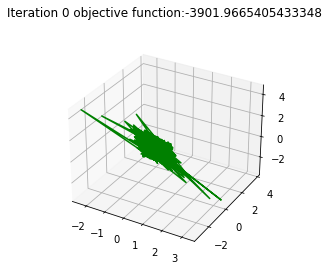

<Figure size 432x288 with 0 Axes>

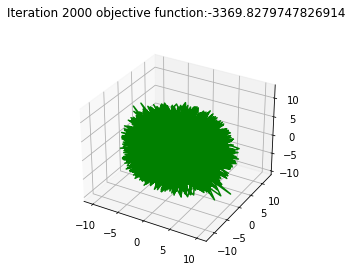

<Figure size 432x288 with 0 Axes>

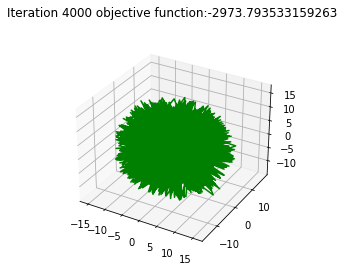

<Figure size 432x288 with 0 Axes>

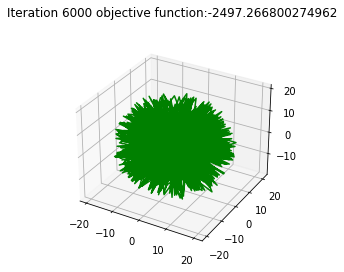

<Figure size 432x288 with 0 Axes>

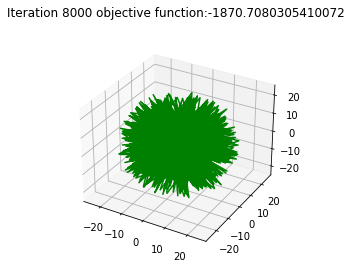

In [15]:
## Optimization
## Initialize Structure
#=========================================================================
smooth_factor = 1e-6 ; # for numerical stability
LEARNING_RATE = 0.1; # Specify the learning rate
NEAR_ZERO =0.00001; # used to signify a boundary of convergence
MAX_ITERATION = 10000; # maximum number of iterations
NUM_FIGURES_OUTPUT=5

thisStr =  [];
R = [-0.5,0.5];
for i in range(n):
    xyz = np.array([random.random(),random.random(),random.random()]) * (R[1]-R[0]) + min(R) 
    thisStr.append(xyz)
print(xyz)

## Variables declaration
#=========================================================================
thislen = n

Sum_Grad = np.zeros(thislen);
variables = thisStr;
oldobj = 0;

## Calculate Objective function [ requires variables and derivatives]
#=========================================================================

tmper2 = gradientCalculator(thislen) # returns the cost and derivative(change)
change = tmper2[0]
cost = tmper2[1]

print(tmper2)

## updateVariables [ use current coordinate and derivatives] 
#=========================================================================
for i in range(thislen) :
    Sum_Grad[i-1] =  Sum_Grad[i-1] + (sum(change[i,:])**2);
    denum = smooth_factor + Sum_Grad[i-1];
    adagrad = (LEARNING_RATE * change[i]/np.sqrt(denum));
    variables[i] = variables[i] +  adagrad;

## loop until convergence
#=========================================================================
count = 0;
oldobj = cost;

converge = isconvergence(change, cost, NEAR_ZERO);
while(count < MAX_ITERATION and ~converge ) :
       
    # Objective function % returns cost and derivative
    tmper2 = gradientCalculator(thislen) # returns the cost and derivative(change)
    change = tmper2[0]
    cost = tmper2[1]
    newobj = cost;
    # update variables with gradient
    for i in range(thislen):
        Sum_Grad[i-1] =  Sum_Grad[i-1] + (sum(change[i,:]**2))
        denum = smooth_factor + Sum_Grad[i-1];
        adagrad = (LEARNING_RATE * change[i]/np.sqrt(denum));
        variables[i] = variables[i] +  adagrad
    
    converge = isconvergence(change, cost, NEAR_ZERO); # Alternative  converge = abs(newobj - oldobj); 
    
    oldobj = newobj;
    # visualize structure MAX 20
    if count in range(0, MAX_ITERATION, int(MAX_ITERATION/NUM_FIGURES_OUTPUT)) :
        titleStr = 'Iteration ' + str(count) + ' objective function:'+ str(newobj) +'\n';
        xyzNew = convert2xyz(n,variables);
        fig = plt.figure()
        fig.clear(True) 
        
        ax = plt.axes(projection ='3d') 
        ax.plot(xyzNew[:,0],xyzNew[:,1],xyzNew[:,2], 'green');
        plt.title(titleStr)
        plt.show()
    count = count + 1; 

In [16]:
#========================================================================
# scoring using spearman correlation, pearson correlation and  RMSD     
#------------------------------------------------------------------------
# calculate rmse    
SUM = 0.0;

Len = int(n * (n - 1) / 2) 
Dist = np.zeros(Len);
WishDist = np.zeros(Len);
count = 1;
structure = variables;
for k in range(len(lstCons)):
    i = lstCons[k,0];    j = lstCons[k,1];    IF = lstCons[k,2];  dist = lstCons[k,3];
    # structure distance   
    x1=structure[k-1][0];  x2=structure[k][0];
    y1=structure[k-1][1];  y2=structure[k][1];
    z1=structure[k-1][2];  z2=structure[k][2];
    
    str_dist = calEuclidianDist(x1,y1,z1,x2,y2,z2 );
    SUM = SUM + ((str_dist - dist)**2);
       
    # calculate spearman_correlation and Pearson correlation
    if (i != j and IF > 0 and count<=Len  ):   
        Dist[count] = str_dist;
        WishDist[count]= dist;
        count = count + 1
        
SUM = SUM / len(lstCons);    
rmse = np.sqrt(SUM);

print("RMSE  : ", rmse)

# let's convert to a dataframe
df = pd.DataFrame({'Dist': Dist, 'wishDist': WishDist})
pearsonCoeff = df.corr(method = 'pearson')
spearmanCoeff = df.corr(method = 'spearman')

print("pearson coeff : \n", pearsonCoeff)
print("spearman Coeff : \n", spearmanCoeff)

RMSE  :  1.9643471502241059
pearson coeff : 
               Dist  wishDist
Dist      1.000000  0.998723
wishDist  0.998723  1.000000
spearman Coeff : 
           Dist  wishDist
Dist       1.0       1.0
wishDist   1.0       1.0


In [17]:
class outputObj:
    def __init__(self, xyzData, outputFile):
        self.xyzData = xyzData
        self.outputFile = outputFile
        
        #defaults
        self.recordName = []
        for i in range(len(xyzData)):
            self.recordName.append('ATOM')
            

    def myfunc(self):
        print("Hello my name is David")

In [18]:
## -- mat2PDB.m --
#
# this function creates a PDB from coordinate data. Represent all inputs as
# a structure field for it to be read. The output format is as given in
# online documentation (as of July 2012 when writing this program)
# http://www.wwpdb.org/documentation/format33/sect9.html#ATOM
#
# Make sure all data input is one-dimensional with the same length. If 
# they are not the same length, the program ignores user input, states 
# an error, and uses defaults. All string inputs should be in cell-format.
# Keep in mind the "element" and "charge" inputs are strings in 
# cell-format, not numbers. 
#
#
# -- required inputs (3) --
#
# input value        meaning
#
# input.X            orthagonal X coordinate data (angstroms)
# input.Y            orthagonal Y coordinate data (angstroms)
# input.Z            orthagonal Z coordinate data (angstroms)
#
# -- optional inputs (12): generates defaults when not user-specified --
#
# input value        meaning                           default value
#
# input.outfile      output file name                 "mat2PDB.pdb"
# input.recordName   output record name of atoms      "ATOM"
# input.atomNum      atom serial number                sequential number
# input.atomName     name of atoms                    "OW" (water oxygen)
# input.altLoc       alt. location indicator          " "
# input.resName      name of residue                  "SOL" (water)
# 
# input.chainID      protein chain identifier         "A"
# input.resNum       residue sequence number           sequential number
# input.occupancy    occupancy factor                 "1.00"
# input.betaFactor   beta factor, temperature         "0.00"
# input.element      element symbol                   "O" (oxygen)
# input.charge       atomic charge                    " "
#
#
# -- example uses --
#
# # translates both X and Y coordinates of 3IJU.pdb by 5 angstroms
# PDBdata = pdb2mat('3IJU.pdb');
# PDBdata.X = PDBdata.X + 5;
# PDBdata.Y = PDBdata.Y + 5;
# mat2pdb(PDBdata)
# 
# # make a PDB with 30 atoms in random places within a 10 angstrom box
# data.X = rand(1,20)*10;
# data.Y = rand(1,20)*10;
# data.Z = rand(1,20)*10;
# mat2pdb(data)
#
# 

def fillWithSpace(val,sizeGoal,left=False):
    if left == False:
        while len(val) < sizeGoal:
            val = " " + val
    else:
        while len(val) < sizeGoal:
            val =  val + " " 
    return val

def xyzOutFormat(P):
    nP = format(P, '8.3f');
    nP = fillWithSpace(nP,8)
    return nP

def occupancyOutFormat(P):
    nP = format(P, '6.2f');
    return nP

def mat2pdb(inputO):
## review XYZ coordinate data 
# coordinate data is required! Checking XYZ input
    if len(inputO.xyzData[0,:]) != 3:
        fprintf('we need xyz coordinate data to make a PDB!!\n\texiting...\n');
        return;

    X = inputO.xyzData[:,0];
    Y = inputO.xyzData[:,1];
    Z = inputO.xyzData[:,2];


    # in case optional data data not given, fill in blanks
    if ~hasattr(inputO, 'atomNum'):
        inputO.atomNum = range(len(X));
    
    if ~hasattr(inputO, 'atomName'):
        inputO.atomName = []
        for i in range(len(X)):
            inputO.atomName.append("CA ")
    
    if ~hasattr(inputO, 'altLoc'):
        inputO.altLoc = []
        for i in range(len(X)):
            inputO.altLoc.append(" ")
    
    if ~hasattr(inputO, 'resName'):
        inputO.resName = []
        for i in range(len(X)):
            inputO.resName.append("MET ")
    
    if ~hasattr(inputO, 'chainID'):
        inputO.chainID = []
        for i in range(len(X)):
            inputO.chainID.append('B')
    
    if ~hasattr(inputO, 'resNum'):
        inputO.resNum = range(len(X));
    
    if ~hasattr(inputO, 'occupancy'):
        inputO.occupancy = np.ones(len(X));

    
    if ~hasattr(inputO, 'betaFactor'):
        inputO.betaFactor = np.zeros(len(X));
    
    if ~hasattr(inputO, 'element'):
        inputO.element = []
        for i in range(len(X)):
            inputO.element.append('O')
    
    if ~hasattr(inputO, 'charge'):
        inputO.charge = []
        for i in range(len(X)):
            inputO.charge.append(" ")
   
    outfile    = inputO.outputFile;
    recordName = inputO.recordName;
    atomNum    = inputO.atomNum;
    atomName   = inputO.atomName;
    altLoc     = inputO.altLoc;
    resName    = inputO.resName;
    chainID    = inputO.chainID;
    resNum     = inputO.resNum;
    occupancy  = inputO.occupancy;
    betaFactor = inputO.betaFactor;## temperature
    
    element    = inputO.element;
    charge     = inputO.charge;
    
    ## remove faulty inputs
        ### TODO
    
    ## create PDB

    # open file
    print('outputting PDB in file : ', outfile);
    FILE = open(outfile, 'w');
    aNumStrCorrected = []
    resNumStrCorrected = []

    # output data
    for n in range(len(atomNum)):
        # standard PDB output line

            
        tmpStr = str(resNum[n])
        while len(tmpStr) < 3:
            tmpStr = " " + tmpStr
        resNumStrCorrected.append(tmpStr)
        
        
        inString = (recordName[n] + "  " + fillWithSpace(str(atomNum[n]),5) +" "+ fillWithSpace(atomName[n],4,True) + 
            altLoc[n] + resName[n] + chainID[n] +
            fillWithSpace(str(resNum[n]),4) + " "#Code for insertions of residues 27
            +"   " +xyzOutFormat(X[n]) + xyzOutFormat(Y[n])+ xyzOutFormat(Z[n])
            + fillWithSpace(occupancyOutFormat(occupancy[n]),6) 
            + fillWithSpace(occupancyOutFormat(betaFactor[n]),6) +"       "#7 spaces
            + "    " #Segment identifier
            + fillWithSpace(element[n],3, True ) 
            + fillWithSpace(charge[n],2) +'\n'
        )

                
        
        FILE.write(inString);

        # output progress in terminal
        #if ~(n % 400):
        #    print('Progress : ', 100*n / len(atomNum));
            
    for n in range(len(atomNum)-1):
        inString2 = 'CONECT' + fillWithSpace(str(atomNum[n]),5) + fillWithSpace(str(atomNum[n+1]),5)+ '\n'
        FILE.write(inString2);

    FILE.print('END\n');

    # close file
    print('done! closing file...\n');

    FILE.close();

    

In [19]:
#========================================================================
# create pdb
#------------------------------------------------------------------------
#Increase structure Size

xyz4pdb = convert2xyz(n,variables) 
scale=100/np.amax(xyz4pdb)
xyz4pdb = xyz4pdb* scale
#output pdb file
outputData= np.round_(xyz4pdb ,3 )

outputFile = 'yolo.pdb' #output directory.


if os.path.exists(outputFile):
    os.remove(outputFile)

output = outputObj(outputData,outputFile)
mat2pdb(output) # Converts the mat XYZ coordinates to PDB format.

outputting PDB in file :  yolo.pdb
<_io.TextIOWrapper name='yolo.pdb' mode='w' encoding='UTF-8'> END

done! closing file...



In [ ]:
xyzOutFormat(88888888888.9999)

In [ ]:
outputData